In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Settings import Settings
settings = Settings()
settings

{'pf1': 0.4,
 'pf2': 0.3,
 'sample_size': 2000,
 'prices': array([ 10.,  20.,  30.,  60., 100.], dtype=float32),
 'c1_reasonable_price': 30,
 'c1_elasticity': 0.1,
 'c1_skepticism': 0.01,
 'c1_max_conversion_rate': 0.75,
 'c1_noise_reasonable_price': 0,
 'c1_noise_elasticity': 0.0,
 'c1_noise_max_conversion_rate': 0.0,
 'c2_reasonable_price': 50,
 'c2_elasticity': 0.05,
 'c2_skepticism': 0.05,
 'c2_max_conversion_rate': 0.85,
 'c2_noise_reasonable_price': 0,
 'c2_noise_elasticity': 0.0,
 'c2_noise_max_conversion_rate': 0.0,
 'c3_reasonable_price': 40,
 'c3_elasticity': 0.1,
 'c3_skepticism': 0.008,
 'c3_max_conversion_rate': 0.5,
 'c3_noise_reasonable_price': 0,
 'c3_noise_elasticity': 0.0,
 'c3_noise_max_conversion_rate': 0.0,
 'default_noise': 0.0}

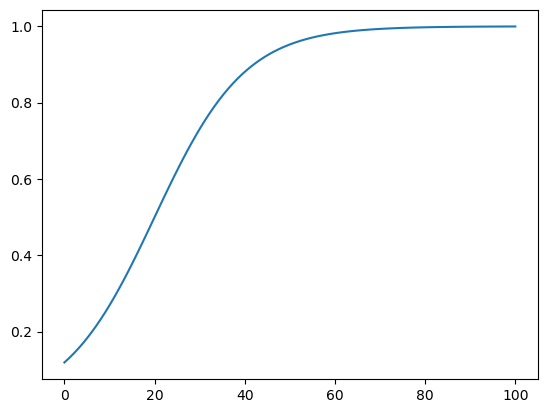

(0.0, 1.0)

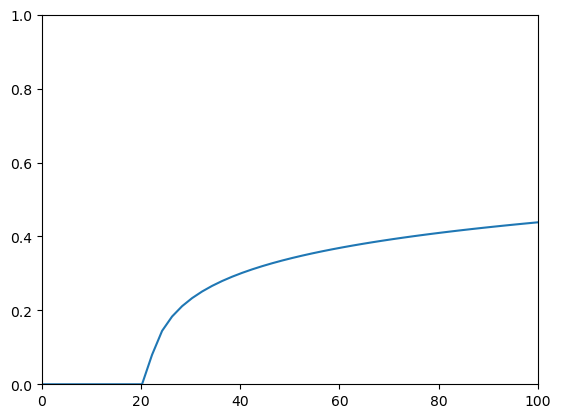

In [16]:
def stuff(x, min_budget, max_budget,  vel):
    if x < min_budget + 1:
        return 0
    else:
        curve = vel * np.log(x - min_budget)
        #min between max_budget and curve
        return min(max_budget, curve)

x = np.linspace(0, 200, 100)
y = [stuff(x, 20, 100, 0.1) for x in x]

plt.plot(x, y)
plt.xlim(0, 100)
plt.ylim(0, 1)
    

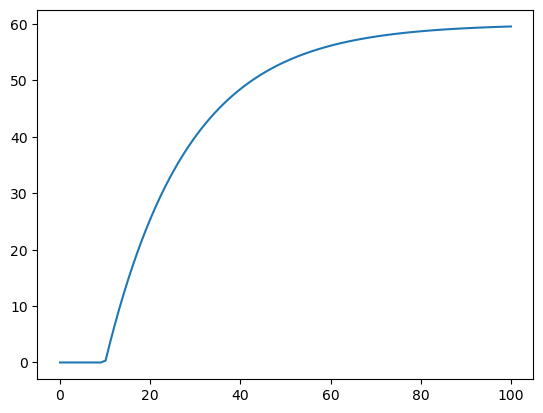

In [41]:
def bid_clicks_curve(x, min_bid = 10, steepness = 0.055, max_clicks = 60):

    if x < min_bid:
        return 0
    return  max_clicks * (1 - np.exp(-steepness * (x - min_bid)))

x = np.linspace(0,100, 100)
y_hat = [y(el) for el in x]

plt.plot(x, y_hat)


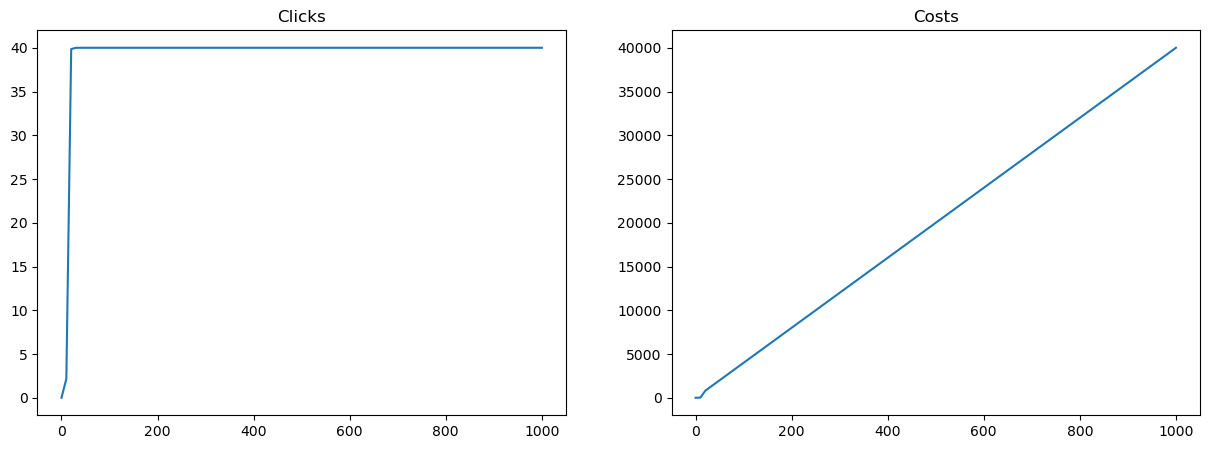

In [6]:
class AA:
    def get_clicks(self, bid, _user_class, min_bid = 10):
        # Define the function for number of clicks for a specific class
        # Return the number of clicks based on the bid and user class
        configs = {"C1": {"max_clicks": 40, "steepness": 0.55, "noise" : 1.0},
                   "C2": {"max_clicks": 80, "steepness": 0.95, "noise" : 2.0},
                   "C3": {"max_clicks": 50, "steepness": 1.2, "noise" : 4}}
        max_clicks = configs[_user_class]["max_clicks"]
        steepness = configs[_user_class]["steepness"]
        noise = configs[_user_class]["noise"]

        if bid < min_bid:
            return 0
        ret_val =   max_clicks * (1 - np.exp(-steepness * (bid - min_bid)))

        return ret_val # + np.random.normal(0, noise)

    def get_costs(self, bid, _user_class, scale_factor = 1):
        return bid * scale_factor * self.get_clicks(bid, _user_class)

env = AA()
bids = np.linspace(0, 1000, 100)
clicks = [env.get_clicks(bid, "C1") for bid in bids]
costs = [env.get_costs(bid, "C1") for bid in bids]

#plot on two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(bids, clicks)
ax1.set_title("Clicks")
ax2.plot(bids, costs)
ax2.set_title("Costs")
plt.show()
